In [48]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [49]:
def download_file_from_gdrive(file_url, filename, out_path: Path, overwrite=False):
    """
    Downloads a file from GDrive given an URL
    :param file_url: a string formated as https://drive.google.com/uc?id=<file_id>
    :param: the desired file name
    :param: the desired folder where the file will be downloaded to
    :param overwrite: whether to overwrite the file if it already exists
    """
    file_exists = (out_path / filename).exists()

    if (file_exists and overwrite) or (not file_exists):
        os.system(f'gdown {file_url} -O {out_path}/{filename}')


FILE_URL = "https://drive.google.com/uc?id=1G3YjM6mR32iPnQ6O3f6rE9BVbhiTiLyU"
FILE_NAME = "medium_posts.csv"
DATA_PATH = Path("../Data_OMLC")

In [50]:
download_file_from_gdrive(file_url=FILE_URL, filename= FILE_NAME, out_path=DATA_PATH)

df = pd.read_csv(DATA_PATH / FILE_NAME,  sep="\t")


df = df[["published", "url"]].dropna().drop_duplicates()


df["published"] = pd.to_datetime(df["published"])


df.sort_values(by=["published"]).head(n=3)	

df = df[(df["published"] > "2012-08-15") & (df["published"] < "2017-06-26")].sort_values(by=["published"])

print(df.head(n=3))
print(df.tail(n=3))

aggr_df = df.groupby("published")[["url"]].count()
aggr_df.columns = ["posts"]
print(aggr_df.head(n=3))

daily_df = aggr_df.resample("D").apply(sum)
print(daily_df.head(n=3))

                             published  \
24630 2012-08-15 00:25:03.373000+00:00   
24631 2012-08-15 00:25:29.419000+00:00   
17811 2012-08-15 00:34:59.502000+00:00   

                                                     url  
24630  https://medium.com/launch-day/jean-attempts-to...  
24631  https://medium.com/launch-day/dan-and-kristin-...  
17811  https://medium.com/i-m-h-o/the-world-is-social...  
                             published  \
62122 2017-06-25 23:36:01.171000+00:00   
72471 2017-06-25 23:41:48.295000+00:00   
83283        2017-06-25 23:51:43+00:00   

                                                     url  
62122  https://medium.com/push-the-pace/the-official-...  
72471  https://medium.com/parti-xyz-developers/%EA%B4...  
83283   http://www.johanr.com/blog/people-support-dreams  
                                  posts
published                              
2012-08-15 00:25:03.373000+00:00      1
2012-08-15 00:25:29.419000+00:00      1
2012-08-15 00:34:59.502000+00:

In [51]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

# Initialize plotly
init_notebook_mode(connected=True)


In [52]:
def plotly_df(df, title="", width=800, height=500):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)

    # in a Jupyter Notebook, the following should work
    iplot(fig, show_link=False)

    # in a Jupyter Book, we save a plot offline and then render it with IFrame
    plot_path = f"../../_static/plotly_htmls/{title}.html".replace(" ", "_")
#     plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))

In [53]:
plotly_df(daily_df, title="Posts on Medium (daily)")

In [54]:
weekly_df = daily_df.resample("W").apply(sum)

In [55]:
plotly_df(weekly_df, title="Posts on Medium (weekly)")


In [56]:
daily_df = daily_df.loc[daily_df.index >= "2015-01-01"]
daily_df.head(n=3)

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11


In [57]:
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)


In [58]:
df = daily_df.reset_index()
df.columns = ["ds", "y"]
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
df["ds"] = df["ds"].dt.tz_convert(None)
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


In [59]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)


,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


In [60]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.7344


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2153.37   0.000494184       175.385      0.3114      0.3114      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2160.38   0.000458011       75.1423      0.2714      0.2714      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2161.39   3.97445e-05       53.4216      0.7608      0.7608      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       2162.44   0.000443765       99.7344   5.847e-06       0.001      535  LS failed, Hessian reset 
     399       2162.58    0.00106453       151.445       0.653       0.653      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       2162.73   0.000518999       103.061   5.922e-06       0.001      6

In [61]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


In [62]:
forecast = m.predict(future)
forecast.tail(n=3)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,278.805167,258.506970,306.829604,278.424979,279.195280,2.127456,2.127456,2.127456,3.470804,3.470804,3.470804,-1.343348,-1.343348,-1.343348,0.0,0.0,0.0,280.932623
905,2017-06-24,279.532346,221.336506,269.540026,279.127019,279.963199,-35.181137,-35.181137,-35.181137,-34.023115,-34.023115,-34.023115,-1.158022,-1.158022,-1.158022,0.0,0.0,0.0,244.351209
906,2017-06-25,280.259524,223.019998,274.147541,279.822029,280.708663,-31.552374,-31.552374,-31.552374,-30.579269,-30.579269,-30.579269,-0.973105,-0.973105,-0.973105,0.0,0.0,0.0,248.707150


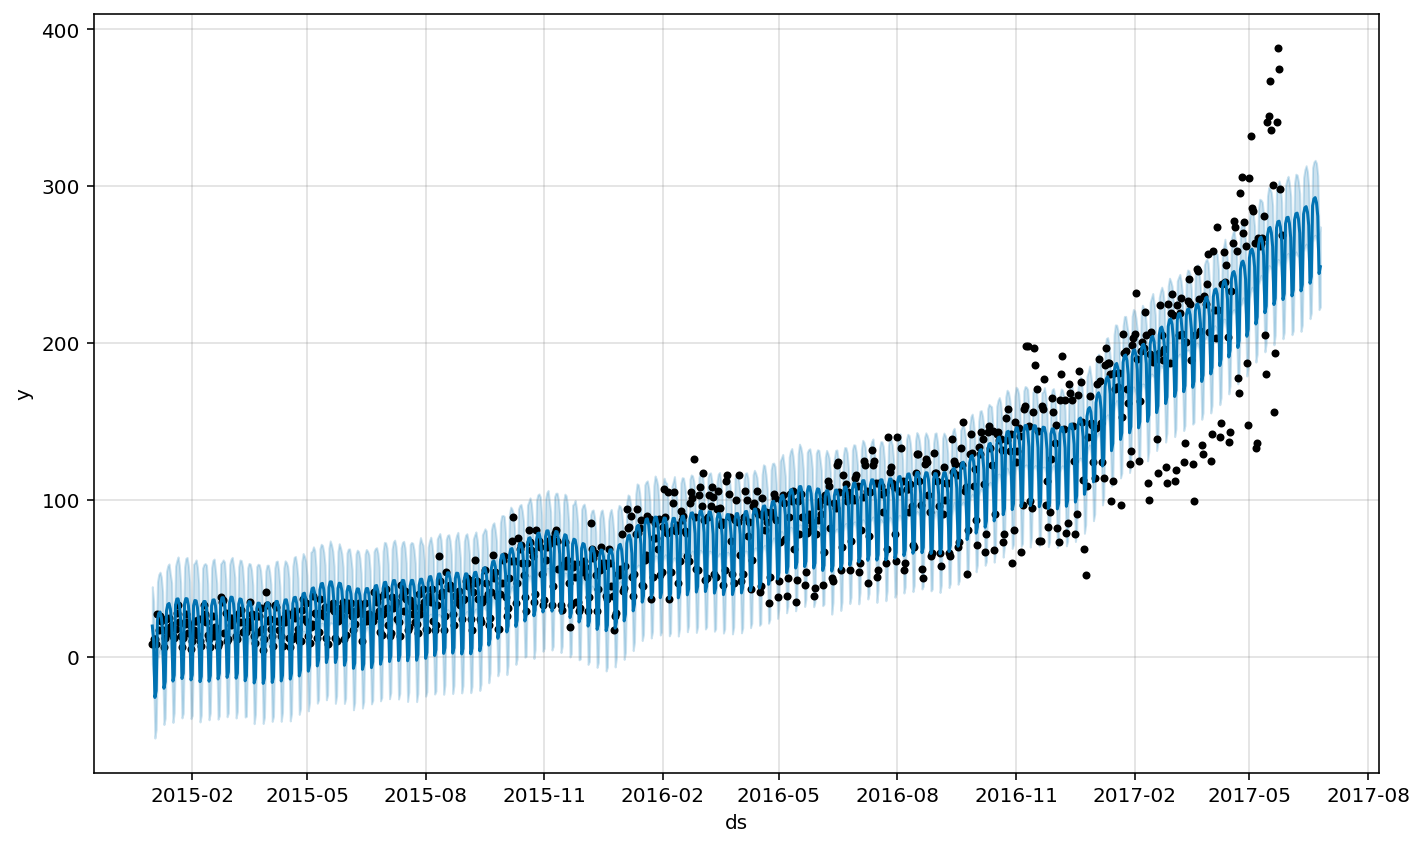

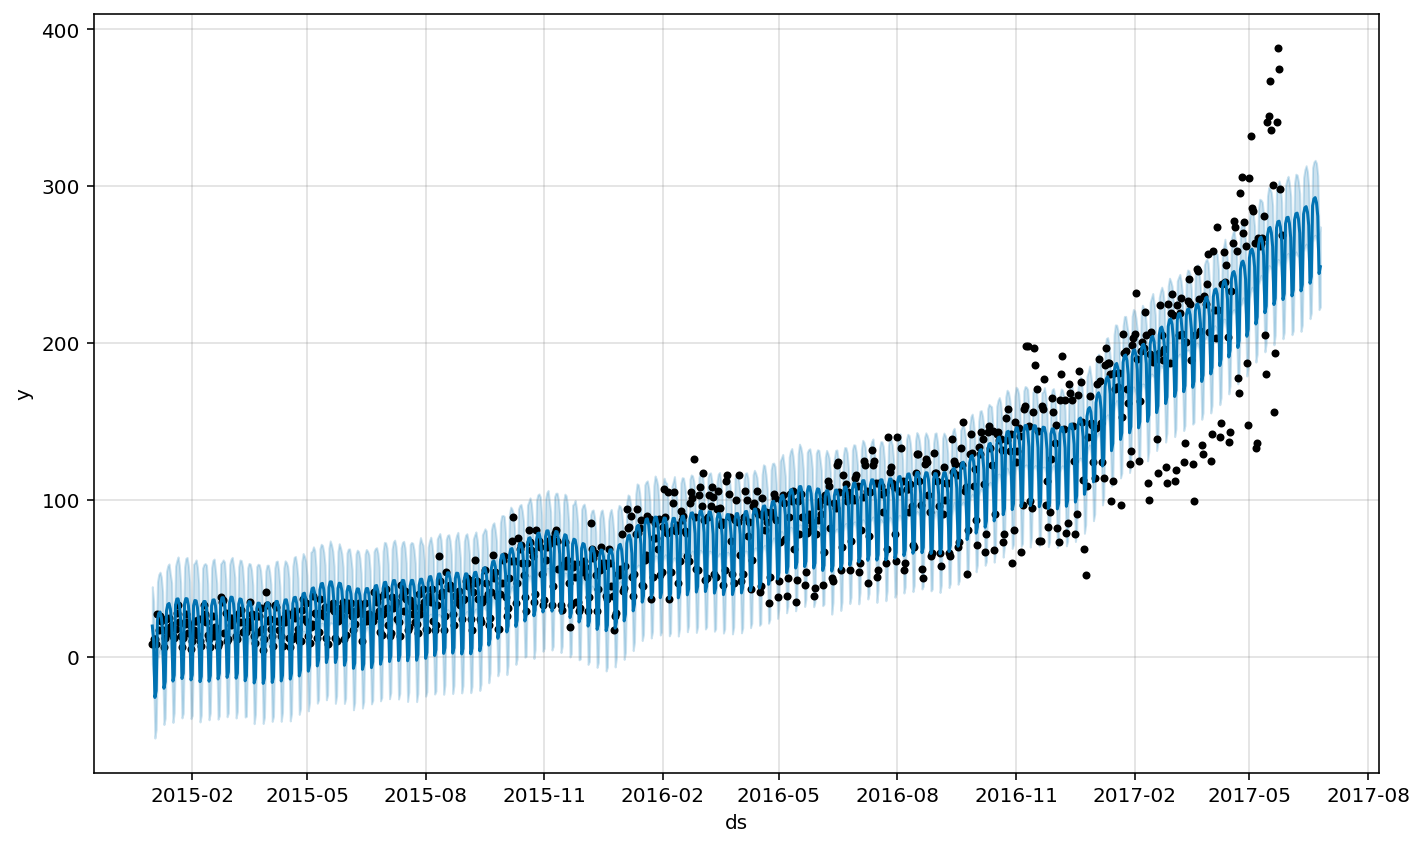

In [63]:
m.plot(forecast)

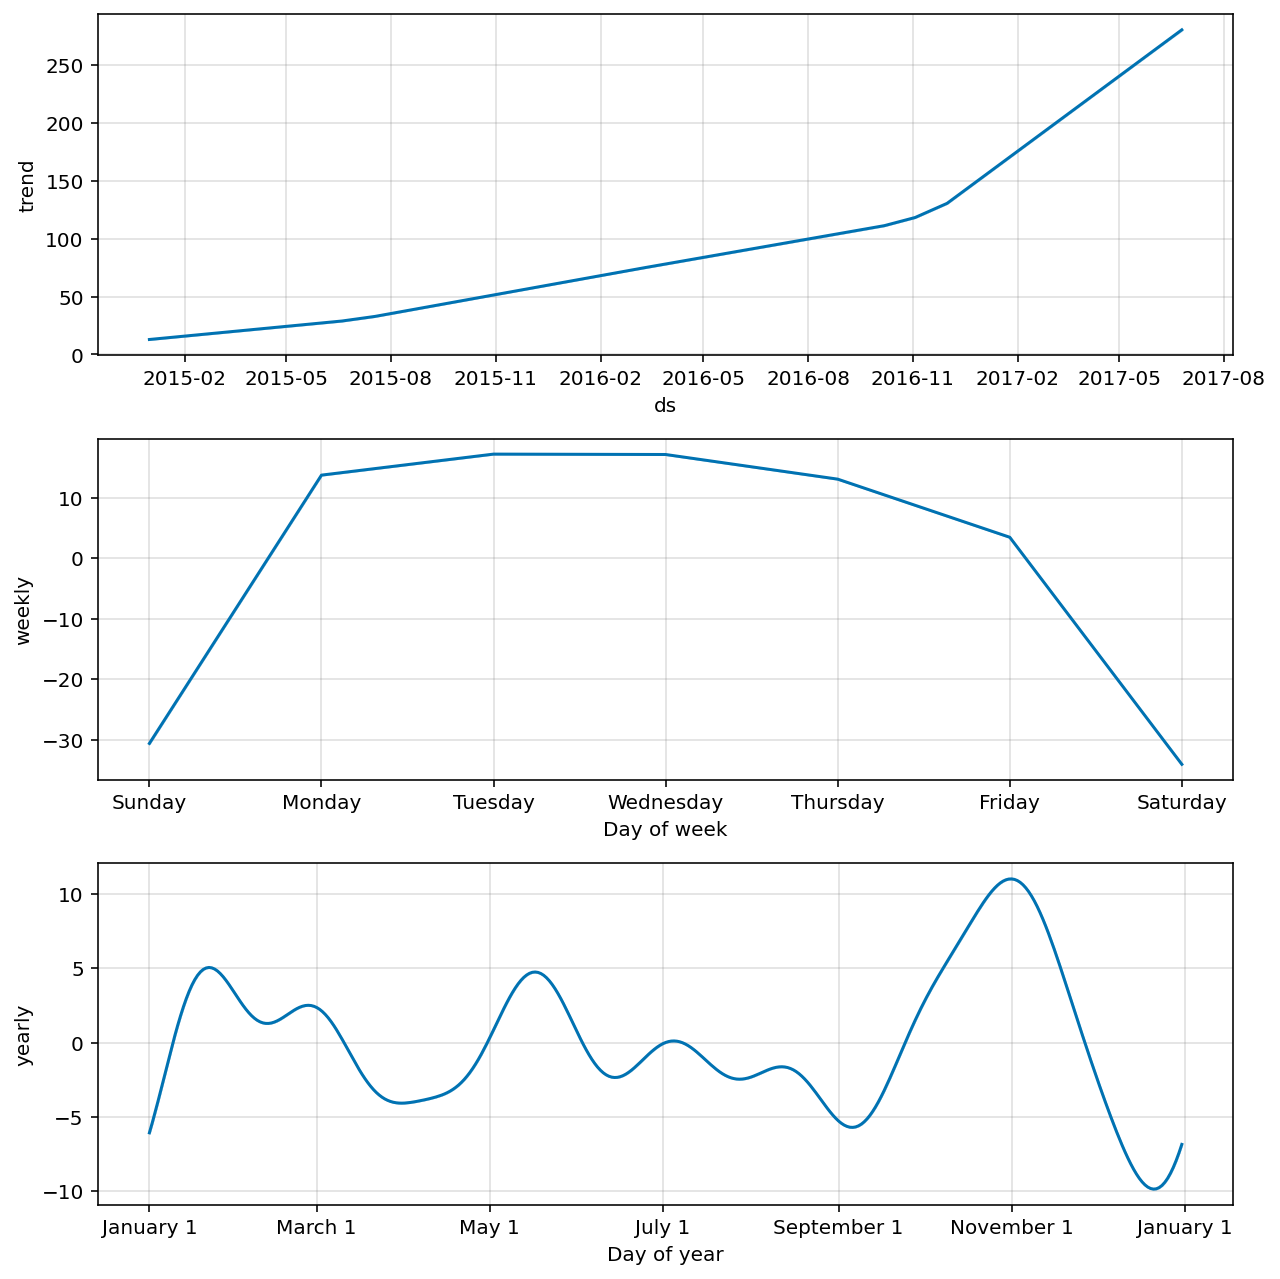

In [64]:
m.plot_components(forecast);

In [65]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [66]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [67]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)


,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,280.932623,258.506970,306.829604,421
2017-06-24,244.351209,221.336506,269.540026,277
2017-06-25,248.707150,223.019998,274.147541,253


In [68]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [72]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)


MAPE 22.50043532422868
MAE 69.28890594695402


In [74]:
def show_forecast(cmp_df, num_predictions, num_values, title, width=800, height=500):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)

    # in a Jupyter Notebook, the following should work
    iplot(fig, show_link=False)

    # in a Jupyter Book, we save a plot offline and then render it with IFrame
    plot_path = f"../../_static/plotly_htmls/{title}.html".replace(" ", "_")
#     plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))


show_forecast(cmp_df, prediction_size, 100, "New posts on Medium")


In [85]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [86]:
train_df2 = train_df.copy().set_index("ds")

In [87]:
train_df2["y"], lambda_prophet = stats.boxcox(train_df2["y"])
train_df2.reset_index(inplace=True)

In [88]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.93811
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       2510.43   0.000382061       225.686   4.668e-06       0.001      111  LS failed, Hessian reset 
      99       2515.53     0.0033527       427.476           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       2517.61   8.22907e-05       94.3796   5.154e-07       0.001      309  LS failed, Hessian reset 
     199       2517.74   0.000735288       169.842       5.483      0.5483      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2517.95   2.23667e-05       64.4893      0.1431      0.5088      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       2517.95    2.5932e-05       76.1773   2.675e-07       0.001      542  LS failed, Hessian rese

In [89]:
for column in ["yhat", "yhat_lower", "yhat_upper"]:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [90]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.946040340803332
MAE 40.56380672158237


In [91]:
show_forecast(cmp_df, prediction_size, 100, "No transformations")
show_forecast(cmp_df2, prediction_size, 100, "Box–Cox transformation")